In [ ]:
# Pin NumPy to a version compatible with datasets
!pip install numpy==1.23.5 --quiet

# Now restart the Python runtime so that the old, incompatible NumPy is unloaded
import os
os.kill(os.getpid(), 9)

In [1]:
!pip install transformers datasets evaluate timm captum wandb --quiet

In [3]:
import os
# 1) Early opt‑out for the env var
os.environ["HF_DATASETS_DISABLE_PROGRESS_BARS"] = "1"

import random
import torch
import numpy as np
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from io import BytesIO
import torch.nn as nn
from transformers import get_cosine_schedule_with_warmup
import timm
from torch.optim import AdamW
from tabulate import tabulate

# 1) Fix seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# config
config = {
    "dataset_name":     "cifar100",
    "num_labels":       100,
    "train_frac":       0.80,
    "val_frac":         0.10,
    "holdout_frac":     0.10,
    "batch_size_train": 128,
    "batch_size_val":   256,
    "max_epochs":       25,
    "patience":         5,
    "warmup_epochs":    3,
    "output_dir":       "./vit-cifar100-checkpoints",
    "sweep_variants": [
        {"name": "A", "lr": 5e-5, "weight_decay": 0.05},
        {"name": "B", "lr": 1e-4, "weight_decay": 0.02},
        {"name": "C", "lr": 3e-5, "weight_decay": 0.10},
    ],
}
os.makedirs(config["output_dir"], exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### helper functions

In [4]:
def print_heading(kind: str, number: int, description: str):
    label = f"{kind} {number}"
    print(f"\n\033[1m{label}\033[0m. {description}")

### Loading in CIFAR-100

In [9]:
import os
import warnings
import torch
import torch.nn as nn
import timm
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup
from datasets import load_dataset, logging as hf_logging, disable_progress_bar
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from io import BytesIO
from math import ceil

# ─── 0) Silence HF and deprecation warnings ─────────────────────────────
os.environ["HF_DATASETS_DISABLE_PROGRESS_BARS"] = "1"
hf_logging.set_verbosity_error()
disable_progress_bar()
warnings.filterwarnings("ignore", category=FutureWarning)

# ─── 1) Load & split the HuggingFace dataset ────────────────────────────
ds = load_dataset(config["dataset_name"])["train"]
split1   = ds.train_test_split(test_size=config["holdout_frac"], seed=seed)
tmp, hold = split1["train"], split1["test"]
val_prop = config["val_frac"] / (config["train_frac"] + config["val_frac"])
split2   = tmp.train_test_split(test_size=val_prop, seed=seed)
train_ds, val_ds, holdout_ds = split2["train"], split2["test"], hold

# ─── 2) Define transforms & preprocess helper ───────────────────────────
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

def preprocess_batch(batch, train: bool):
    imgs, labels = batch["img"], batch["fine_label"]
    pxs, lbs = [], []
    for img, lbl in zip(imgs, labels):
        if isinstance(img, list):
            img = img[0]
        if not isinstance(img, Image.Image):
            buf = img if isinstance(img, (bytes, bytearray)) else img.tobytes()
            img = Image.open(BytesIO(buf)) if isinstance(buf, (bytes, bytearray)) else Image.fromarray(img)
        pil = img.convert("RGB")
        transform = train_tf if train else eval_tf
        pxs.append(transform(pil))
        lbs.append(lbl)
    return {"pixel_values": pxs, "labels": lbs}

batch_size = 1000

# preprocess splits
train_ds   = train_ds.map(
    lambda b: preprocess_batch(b, train=True),
    batched=True, batch_size=batch_size, remove_columns=["img"], num_proc=1
)
val_ds     = val_ds.map(
    lambda b: preprocess_batch(b, train=False),
    batched=True, batch_size=batch_size, remove_columns=["img"], num_proc=1
)
holdout_ds = holdout_ds.map(
    lambda b: preprocess_batch(b, train=False),
    batched=True, batch_size=batch_size, remove_columns=["img"], num_proc=1
)

# build DataLoaders
for ds_ in (train_ds, val_ds, holdout_ds):
    ds_.set_format(type="torch", columns=["pixel_values", "labels"])

num_workers = max(1, os.cpu_count() - 1)
train_loader   = DataLoader(train_ds,   batch_size=config["batch_size_train"],
                            shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader     = DataLoader(val_ds,     batch_size=config["batch_size_val"],
                            shuffle=False, num_workers=num_workers, pin_memory=True)
holdout_loader = DataLoader(holdout_ds, batch_size=config["batch_size_val"],
                            shuffle=False, num_workers=num_workers, pin_memory=True)

# summary print-out
print(f"Loaded data ⇒ Train: {len(train_ds)}, Val: {len(val_ds)}, Holdout: {len(holdout_ds)}")

Preprocessing train:  28%|██▊       | 11/40 [07:24<19:32, 40.42s/batch]


Loaded data ⇒ Train: 40000, Val: 5000, Holdout: 5000


## 1 - Fine-tuning

In [12]:
import os
import gc
import torch
import timm
import wandb
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup
from google.colab import userdata

# login to W&B
os.environ["WANDB_API_KEY"] = userdata.get("WANDB_API_KEY")
wandb.login()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# sweep over variants
for var in config["sweep_variants"]:
    # ensure a clean slate on the GPU
    torch.cuda.empty_cache()
    gc.collect()

    run = wandb.init(
        project="vit-cifar100",
        name=f"ViT-LN-{var['name']}",
        config={**config, **var},
        reinit=True
    )

    # build model + optimizer + scheduler
    model = timm.create_model(
        "vit_base_patch16_224",
        pretrained=True,
        num_classes=config["num_labels"]
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=var["lr"], weight_decay=var["weight_decay"])
    criterion = nn.CrossEntropyLoss()
    scaler    = torch.cuda.amp.GradScaler()

    total_steps  = len(train_loader) * config["max_epochs"]
    warmup_steps = len(train_loader) * config["warmup_epochs"]
    scheduler    = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    best_val_acc, wait = 0.0, 0
    ckpt_path = os.path.join(config["output_dir"], f"best_val_acc_{var['name']}.pt")

    for epoch in range(1, config["max_epochs"] + 1):
        # training
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            imgs, labels = batch["pixel_values"].to(device), batch["labels"].to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                logits = model(imgs)
                loss   = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)

        # validation (no grad, frees up memory)
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for batch in val_loader:
                imgs, labels = batch["pixel_values"].to(device), batch["labels"].to(device)
                preds = model(imgs).argmax(dim=-1)
                correct += (preds == labels).sum().item()
                total   += labels.size(0)
        val_acc = correct / total

        # log to W&B
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_acc":   val_acc
        })

        # early stopping & checkpoint
        if val_acc > best_val_acc:
            best_val_acc, wait = val_acc, 0
            torch.save(model.state_dict(), ckpt_path)
            wandb.run.summary["best_val_acc"] = best_val_acc
            wandb.save(ckpt_path)
        else:
            wait += 1
            if wait >= config["patience"]:
                print("Early stopping triggered.")
                break

    print(f"Variant {var['name']} done. Best Val Acc = {best_val_acc:.4f}")
    run.finish()

    # cleanup before next variant
    del model, optimizer, scheduler
    torch.cuda.empty_cache()
    gc.collect()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁█
train_loss,█▁
val_acc,▁█
best_val_acc,0.8656
epoch,2
train_loss,0.95046
val_acc,0.8656


Early stopping triggered.
Variant A done. Best Val Acc = 0.8838


epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,█▃▂▂▁▁▁▁▁▁▁
val_acc,▁▇▆▇██▇▆▆▆▇
best_val_acc,0.8838
epoch,11
train_loss,0.03485
val_acc,0.8774


Early stopping triggered.
Variant B done. Best Val Acc = 0.8642


epoch,▁▂▃▅▆▇█
train_loss,█▃▃▂▂▁▁
val_acc,▅█▂▂▁▄▁
best_val_acc,0.8642
epoch,7
train_loss,0.16128
val_acc,0.8384


Early stopping triggered.
Variant C done. Best Val Acc = 0.9022


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▇▆▇▇▇████▇▇▇▇
best_val_acc,0.9022
epoch,14
train_loss,0.00843
val_acc,0.894


## 2 - Interpretability

### 2.1 - Attention Entropy

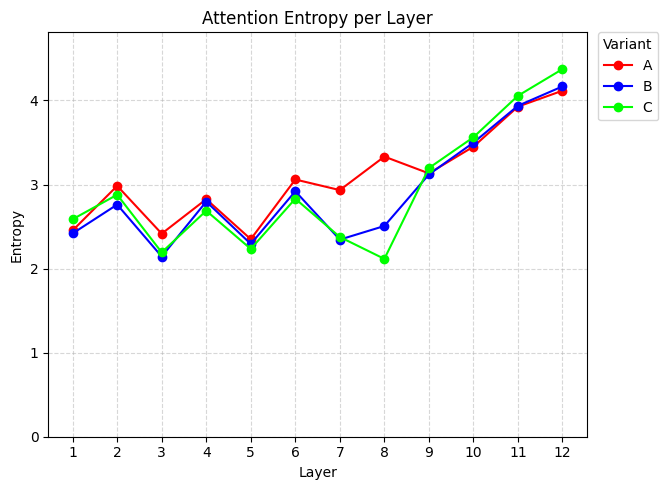

In [19]:
import os
import torch
import torch.nn.functional as F
import timm
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 1) Define variants and colors ────────────────────────────────────────
variants = {
    "A": {"ckpt": "best_val_acc_A.pt", "color": "#FF0000"},
    "B": {"ckpt": "best_val_acc_B.pt", "color": "#0000FF"},
    "C": {"ckpt": "best_val_acc_C.pt", "color": "#00FF00"},
}

# ─── 2) Hook maker: recompute softmax attention & accumulate entropy ────
def make_entropy_hook(layer_idx, entropy_sum, sample_cnt, eps=1e-12):
    def hook(module, inp, out):
        # inp[0] is x: [B, N, C]
        x = inp[0]
        B, N, C = x.shape
        # compute Q, K
        qkv = module.qkv(x)  # [B, N, 3*C]
        head_dim = C // module.num_heads
        qkv = qkv.view(B, N, 3, module.num_heads, head_dim).permute(2, 0, 3, 1, 4)
        q, k, _ = qkv[0], qkv[1], qkv[2]
        # scaled dot‑product + softmax
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = F.softmax(attn, dim=-1)  # [B, heads, N, N]
        # pick [CLS]→tokens row
        cls_attn = attn[:, :, 0, :]      # [B, heads, N]
        ent = -(cls_attn * (cls_attn + eps).log()).sum(-1)  # [B, heads]
        entropy_sum[layer_idx] += ent.sum().cpu()
        sample_cnt[layer_idx]  += ent.numel()
    return hook

# ─── 3) Compute per‑block mean entropy for each variant ──────────────────
results = {}
for name, info in variants.items():
    # load model checkpoint
    path = os.path.join(config["output_dir"], info["ckpt"])
    model = timm.create_model("vit_base_patch16_224",
                              pretrained=False,
                              num_classes=config["num_labels"]).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

    # prepare accumulators
    num_layers  = len(model.blocks)
    entropy_sum = torch.zeros(num_layers)
    sample_cnt  = torch.zeros(num_layers)

    # register hooks on each attention module
    hooks = []
    for i, blk in enumerate(model.blocks):
        h = blk.attn.register_forward_hook(
            make_entropy_hook(i, entropy_sum, sample_cnt)
        )
        hooks.append(h)

    # single forward pass over validation set
    with torch.no_grad():
        for batch in val_loader:
            imgs = batch["pixel_values"].to(device)
            _    = model(imgs)

    # remove hooks
    for h in hooks:
        h.remove()

    # store mean entropy per layer
    results[name] = (entropy_sum / sample_cnt).numpy()

# ─── 4) Plot all variants together ────────────────────────────────────────
num_layers = len(next(iter(results.values())))
layers     = np.arange(1, num_layers + 1)
y_max      = max(vals.max() for vals in results.values()) * 1.1

fig, ax = plt.subplots(figsize=(8, 5))
for name, info in variants.items():
    ax.plot(
        layers,
        results[name],
        marker='o',
        color=info["color"],
        label=name
    )

ax.set_xlabel("Layer")
ax.set_ylabel("Entropy")
ax.set_title("Attention Entropy per Layer")
ax.set_xticks(layers)
ax.set_ylim(0, y_max)
ax.grid(True, linestyle="--", alpha=0.5)

# place legend outside plot on top-right
ax.legend(
    title="Variant",
    loc="upper left",
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave room on right for legend
plt.savefig("attention_entropy_all_variants.png", dpi=150)
plt.show()

### 2.2 - Saliency-density (focus) Score

In [ ]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from captum.attr import Saliency
import timm

def load_fp32_models(ckpt_path, num_labels, device):
    """
    Returns a tuple (model_gpu, model_cpu, saliency_cpu).
    - model_gpu: loaded on `device`, used for forward → pred
    - model_cpu: loaded on CPU, used for saliency backward
    - saliency_cpu: Captum Saliency wrapped around model_cpu
    """
    # instantiate both
    model_gpu = timm.create_model(
        "vit_base_patch16_224", pretrained=False, num_classes=num_labels
    )
    model_cpu = timm.create_model(
        "vit_base_patch16_224", pretrained=False, num_classes=num_labels
    )
    # load checkpoint onto CPU
    state = torch.load(ckpt_path, map_location="cpu")
    model_gpu.load_state_dict(state)
    model_cpu.load_state_dict(state)
    # free raw state dict
    del state
    torch.cuda.empty_cache()
    # move GPU model to device
    model_gpu.eval().to(device)
    # keep CPU model on cpu
    model_cpu.eval().to("cpu")
    saliency_cpu = Saliency(model_cpu)
    return model_gpu, model_cpu, saliency_cpu

def compute_fp32_focus(
    ckpt_path,
    val_ds,
    device,
    max_images=500,
    pct=0.05,
    num_workers=2
):
    """
    Computes saliency‐density focus scores for the FP32 model.
    Returns (mean_focus, std_focus).
    """
    # 1) Prepare models & saliency
    model_gpu, model_cpu, saliency_cpu = load_fp32_models(
        ckpt_path, num_labels=config["num_labels"], device=device
    )

    # 2) Single‐image DataLoader
    loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=num_workers)

    # 3) Loop & accumulate
    focus_scores = []
    processed = 0
    for batch in loader:
        inp_gpu = batch["pixel_values"].to(device)
        with torch.no_grad():
            out  = model_gpu(inp_gpu)
            pred = out.argmax(dim=-1).cpu()

        inp_cpu = inp_gpu.cpu().detach().requires_grad_()
        grad_cpu = saliency_cpu.attribute(inp_cpu, target=pred)

        sal_map = grad_cpu.abs().max(1)[0].squeeze(0).numpy()
        flat    = sal_map.ravel()
        thr     = np.percentile(flat, 100*(1-pct))
        focus_scores.append((flat >= thr).sum() / flat.size)

        processed += 1
        if processed >= max_images:
            break

    # 4) Compute stats
    mean_focus = np.mean(focus_scores)
    std_focus  = np.std(focus_scores)
    return mean_focus, std_focus

In [ ]:
ckpt_path = os.path.join(config["output_dir"], "best_val_acc.pt")
mean_fp32, std_fp32 = compute_fp32_focus(ckpt_path, val_ds, device)

print(f"Processed up to {min(len(val_ds), 500)} images")
print(f"FP32 focus (top {int(0.05*100)}% pixels): {mean_fp32:.4f} ± {std_fp32:.4f}")

Processed 500 images
ViT‑LN FP32 focus (top 5% pixels): 0.0500 ± 0.0000


## 3 - Compression

In [ ]:
import os
import time
import torch
import timm
import torch.ao.quantization as tq
from tqdm import tqdm

device_cpu = torch.device("cpu")
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quant_dir   = "quantized"
quant_path  = os.path.join(quant_dir, "vit_ln_int8.pt")

def load_fp32_on_cpu(path):
    model = timm.create_model(
        "vit_base_patch16_224", pretrained=False, num_classes=config["num_labels"]
    )
    state = torch.load(path, map_location="cpu")
    model.load_state_dict(state)
    return model.eval().to(device_cpu)

def prepare_static_int8(fp32_cpu_model, calib_loader):
    if hasattr(fp32_cpu_model, "fuse_model"):
        fp32_cpu_model.fuse_model()
    fp32_cpu_model.qconfig = tq.get_default_qconfig("fbgemm")
    tq.prepare(fp32_cpu_model, inplace=True)

    with torch.no_grad():
        for batch in tqdm(calib_loader, desc="Calibrating INT8"):
            fp32_cpu_model(batch["pixel_values"])

    quant_model = tq.convert(fp32_cpu_model, inplace=False)
    os.makedirs(quant_dir, exist_ok=True)
    torch.save(quant_model.state_dict(), quant_path)
    print(f"Saved static‑quantized INT8 model to {quant_path}")
    return quant_model.eval().to(device_cpu)

def load_fp32_on_gpu(path):
    model = timm.create_model(
        "vit_base_patch16_224", pretrained=False, num_classes=config["num_labels"]
    )
    state = torch.load(path, map_location="cpu")
    model.load_state_dict(state)
    return model.eval().to(device_gpu)

def eval_acc(model, loader, device, desc=None):
    model.to(device).eval()
    correct = total = 0
    iterator = tqdm(loader, desc=desc) if desc else loader
    with torch.no_grad():  # inference_mode isn't available in this PyTorch version
        for batch in iterator:
            imgs   = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            preds  = model(imgs).argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    return correct / total

def measure_latency(model, loader, device, runs=20, warmups=10):
    model.to(device).eval()
    imgs = next(iter(loader))["pixel_values"].to(device)

    # warm‑up
    for _ in tqdm(range(warmups), desc="Warm-up"):
        with torch.no_grad():
            model(imgs)

    # timed runs
    start = time.perf_counter()
    for _ in tqdm(range(runs), desc="Measuring latency"):
        with torch.no_grad():
            model(imgs)
    elapsed = time.perf_counter() - start

    return elapsed / runs * 1000  # ms per batch

### 3.1 - Dynamic Quantization

In [ ]:
# 1) Load FP32 on CPU
fp32_path = os.path.join(config["output_dir"], "best_val_acc.pt")
model_fp32_cpu = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=config["num_labels"])
model_fp32_cpu.load_state_dict(torch.load(fp32_path, map_location="cpu"))
model_fp32_cpu.eval()

# 2) Dynamic‐quantize only Linear modules
quant_model_dyn = quantize_dynamic(
    model_fp32_cpu,
    {torch.nn.Linear},
    dtype=torch.qint8
)

# 3) Save
os.makedirs("quantized", exist_ok=True)
dyn_path = "quantized/vit_ln_dynint8.pt"
torch.save(quant_model_dyn.state_dict(), dyn_path)
print(f"Saved dynamic‐quantized model to {dyn_path}")

Saved dynamic‐quantized model to quantized/vit_ln_dynint8.pt


In [ ]:
# CPU eval of FP32 vs Dyn‑INT8 (ViT‑LN)
import os, time, torch
import timm
from tqdm import tqdm

cpu = torch.device("cpu")

# 1) Load models
model_fp32_cpu   = load_fp32_cpu(fp32_path)
quant_model_dyn  = quant_model_dyn.to(cpu)

In [ ]:
acc_dyn  = eval_acc(quant_model_dyn,  val_loader, cpu, desc="Dyn‑INT8 CPU Eval")

lat_dyn  = measure_latency(quant_model_dyn, cpu)

size_dyn  = os.path.getsize(dyn_path)  / 1e6

Dyn‑INT8 CPU Eval: 100%|██████████| 20/20 [09:56<00:00, 29.84s/it]


In [ ]:
print(f"Dyn‑INT8| Acc={acc_dyn*100:.2f}% | Size={size_dyn:.1f} MB | Lat={lat_dyn:.1f} ms")

Dyn‑INT8| Acc=89.86% | Size=88.6 MB | Lat=29456.0 ms


In [59]:
acc_fp32 = eval_acc(model_fp32_cpu, val_loader, cpu, desc="FP32 CPU Eval")

FP32 CPU Eval: 100%|██████████| 20/20 [16:17<00:00, 48.89s/it]


TypeError: measure_latency() missing 1 required positional argument: 'device'

In [60]:
lat_fp32 = measure_latency(model_fp32_cpu, val_loader, cpu)

# 3) Measure sizes
size_fp32 = os.path.getsize(fp32_path) / 1e6

# 5) Print metrics
print(f"FP32    | Acc={acc_fp32*100:.2f}% | Size={size_fp32:.1f} MB | Lat={lat_fp32:.1f} ms")

Latency runs INT8:   8%|▊         | 8/100 [06:33<1:15:27, 49.22s/it]


KeyboardInterrupt: 

In [ ]:
from tabulate import tabulate

# 1) Prepare table rows for FP32 vs Dynamic‑INT8
rows = [
    [
        "ViT‑LN",
        "FP32",
        f"{acc_fp32 * 100:.2f}",
        "0.00",
        f"{size_fp32:.1f}",
        "0.0",
        f"{lat_fp32:.1f}"
    ],
    [
        "ViT‑LN",
        "Dyn‑INT8",
        f"{acc_dyn * 100:.2f}",
        f"{(acc_dyn - acc_fp32) * 100:.2f}",
        f"{size_dyn:.1f}",
        f"{(size_dyn - size_fp32) / size_fp32 * 100:.1f}",
        f"{lat_dyn:.1f}"
    ],
]

# 2) Column headers
headers = [
    "Model", "Format", "Test Acc %", "ΔAcc %",
    "Size (MB)", "ΔSize %", "Latency (ms)"
]

# 3) Print the heading and table
print_heading("Table", 3, "FP32 vs. Dynamic INT8 Quantization Results")
print(tabulate(rows, headers=headers, tablefmt="github"))

NameError: name 'size_fp32_ln' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filter only the INT8 rows
mask = df["Format"] == "INT8"
models    = df.loc[mask, "Model"].tolist()
acc_drops = df.loc[mask, "ΔAcc %"].astype(float).tolist()
size_reds = df.loc[mask, "ΔSize %"].astype(float).tolist()

x = np.arange(len(models))
width = 0.4

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - width/2, acc_drops, width, label="Accuracy drop (%)")
ax.bar(x + width/2, size_reds, width, label="Size reduction (%)")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel("Percentage (%)")
ax.set_title("Figure 4. INT8: Accuracy drop vs Size reduction")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("figure4_acc_vs_size.png", dpi=150)
plt.show()

## 4 - Benchmarking & Comparison